In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from CinemaNet.train_utils import *
from CinemaNet.custom_head import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *
from CinemaNet.data_3000L import *

import wandb

In [3]:
model_name = 'MNetV2-150x266-3000L'

In [4]:
#hide
wandb.init(name='MNetV2-150x266',
           project='Shot Framing -- Supervised (3000L)',
           tags=['MobileNetV2'],
           entity='synopsis',
           reinit=True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/synopsis/Shot+Framing+--+Supervised+%283000L%29/runs/ibm6be8x

Streaming file created twice in same run: /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_044238-ibm6be8x/wandb-events.jsonl
Streaming file created twice in same run: /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_044238-ibm6be8x/wandb-history.jsonl


In [5]:
wandb.run.resumed

True

In [6]:
#hide
%env WANDB_NOTEBOOK_NAME='05-1-MNetV2-150x266-3000L.ipynb'

env: WANDB_NOTEBOOK_NAME='05-1-MNetV2-150x266-3000L.ipynb'


## Setup

### Dataset

Data grabbing functions in `CinemaNet/data_3000L.py`

In [6]:
img_size   = to_film_ar(150)

In [7]:
data = get_data_3000L(img_size)
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium Close-Up,Close-Up,Close-Up,Long,Medium Close-Up
Path: .;

Test: None

6

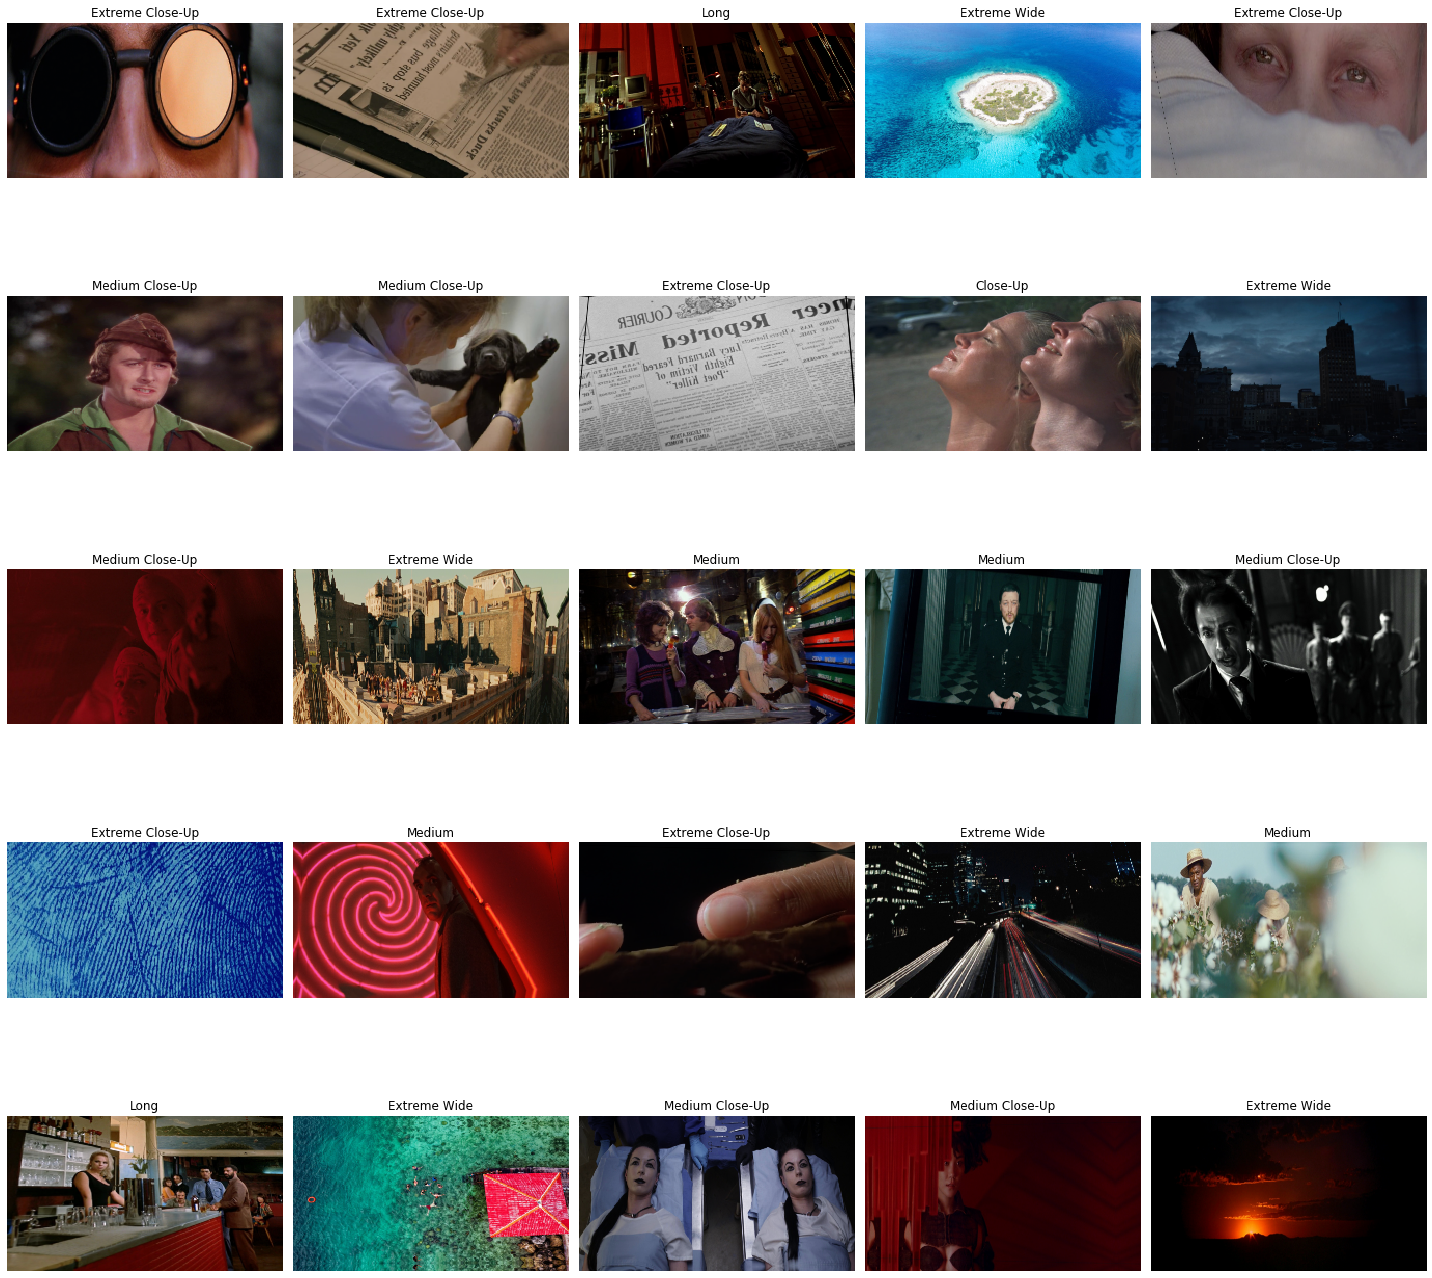

In [8]:
data.c
data.show_batch()

In [8]:
img_size

(150, 266)

## Training (150, 266)

### Frozen -- Head Only

In [9]:
arch = models.mobilenet_v2
learn = cnn_learner(data, arch, pretrained=True, metrics=metrics).to_fp16()

In [10]:
learn.data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium Close-Up,Close-Up,Close-Up,Long,Medium Close-Up
Path: .;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


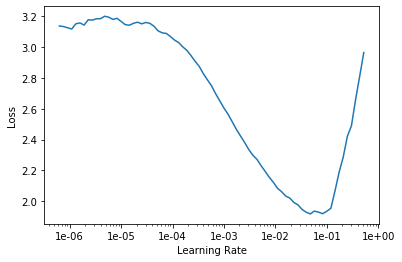

In [14]:
learn.lr_find()
learn.recorder.plot()

In [11]:
def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}', monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images', log='all')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

In [12]:
model_name

'MNetV2-150x266-3000L'

In [13]:
callbacks = get_callbacks(learn, model_name)

In [14]:
len(learn.layer_groups)

3

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.796034,0.766211,0.706602,0.717957,0.753836,00:49
1,1.094394,0.628002,0.785507,0.789304,0.820225,00:44
2,0.752172,0.489428,0.839613,0.836922,0.854951,00:44
3,0.554670,0.516034,0.829308,0.828945,0.855065,00:44
4,0.435889,0.454544,0.848953,0.842545,0.868187,00:43
5,0.333095,0.431201,0.853784,0.854122,0.870913,00:46
6,0.272117,0.423566,0.856039,0.856578,0.873692,00:43
7,0.244026,0.418476,0.858615,0.858275,0.875743,00:44


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.7066022753715515.
Better model found at epoch 0 with accuracy value: 0.7066022753715515.
Better model found at epoch 1 with accuracy value: 0.7855072617530823.
Better model found at epoch 1 with accuracy value: 0.7855072617530823.
Better model found at epoch 2 with accuracy value: 0.8396134972572327.
Better model found at epoch 2 with accuracy value: 0.8396134972572327.
Better model found at epoch 4 with accuracy value: 0.8489533066749573.
Better model found at epoch 4 with accuracy value: 0.8489533066749573.
Better model found at epoch 5 with accuracy value: 0.8537842035293579.
Better model found at epoch 5 with accuracy value: 0.8537842035293579.
Better model found at epoch 6 with accuracy value: 0.8560386300086975.
Better model found at epoch 6 with accuracy value: 0.8560386300086975.
Better model found at epoch 7 with accuracy value: 0.8586151599884033.
Better model found at epoch 7 with accuracy value: 0.8586151599884033.
Loaded

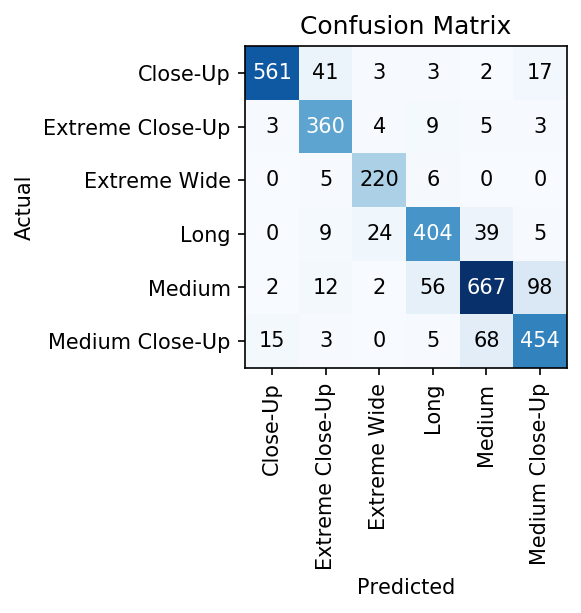

In [15]:
learn.fit_one_cycle(8, 1e-3, callbacks=callbacks)

### Unfrozen

In [21]:
model_name

'MNetV2-150x266-3000L-unfrozen'

In [20]:
learn.unfreeze()
model_name = f'{model_name}-unfrozen'
callbacks = get_callbacks(learn, model_name)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


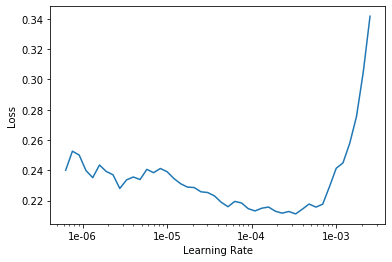

In [22]:
learn.lr_find()
learn.recorder.plot()

In [24]:
callbacks = get_callbacks(learn, model_name, patience=7)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.229249,0.419312,0.857971,0.858071,0.875209,00:45
1,0.216433,0.422449,0.857005,0.858261,0.873631,00:44
2,0.209607,0.412849,0.861836,0.862694,0.879373,00:45
3,0.218103,0.410189,0.864734,0.865628,0.881609,00:45
4,0.202592,0.401741,0.867311,0.867549,0.881540,00:44
5,0.200913,0.420802,0.860870,0.856784,0.878037,00:43
6,0.194865,0.410899,0.865700,0.864605,0.878862,00:43
7,0.173425,0.413542,0.863124,0.861699,0.879169,00:43


Better model found at epoch 0 with accuracy value: 0.8579710125923157.
Better model found at epoch 0 with accuracy value: 0.8579710125923157.


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 2 with accuracy value: 0.861835777759552.
Better model found at epoch 2 with accuracy value: 0.861835777759552.
Better model found at epoch 3 with accuracy value: 0.8647342920303345.
Better model found at epoch 3 with accuracy value: 0.8647342920303345.
Better model found at epoch 4 with accuracy value: 0.8673107624053955.
Better model found at epoch 4 with accuracy value: 0.8673107624053955.
Epoch 8: early stopping
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_031959-ibm6be8x/bestmodel.pth


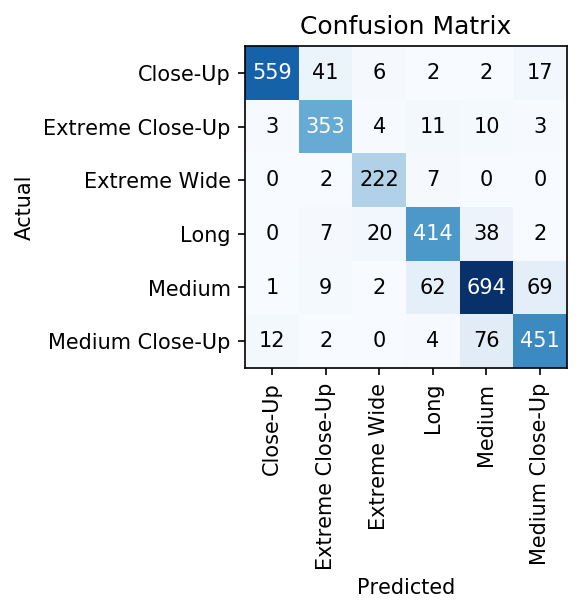

In [27]:
learn.fit_one_cycle(20, slice(1e-6, 1e-4), callbacks=callbacks)

In [38]:
config = wandb.config

config.img_size = img_size
config.batch_size = learn.data.batch_size
config.len_train = len(learn.data.train_ds)
config.len_valid = len(learn.data.valid_ds)
config.model = re.sub('-unfrozen', '', model_name)

Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


### Export to CoreML

In [39]:
from CinemaNet.convert import *
from CinemaNet.custom_head import *

In [6]:
model_name

'MNetV2-150x266-3000L'

In [41]:
learn = cnn_learner(data, arch)
learn.load(model_name);

In [7]:
model_fname=re.sub('-unfrozen', '', model_name)
model_fname

'MNetV2-150x266-3000L'

In [44]:
torch_to_coreml(learn.model, data.c,
                model_fname=model_fname,
                img_size=img_size)

1/162: Converting Node Type Conv
2/162: Converting Node Type BatchNormalization
3/162: Converting Node Type Clip
4/162: Converting Node Type Conv
5/162: Converting Node Type BatchNormalization
6/162: Converting Node Type Clip
7/162: Converting Node Type Conv
8/162: Converting Node Type BatchNormalization
9/162: Converting Node Type Conv
10/162: Converting Node Type BatchNormalization
11/162: Converting Node Type Clip
12/162: Converting Node Type Conv
13/162: Converting Node Type BatchNormalization
14/162: Converting Node Type Clip
15/162: Converting Node Type Conv
16/162: Converting Node Type BatchNormalization
17/162: Converting Node Type Conv
18/162: Converting Node Type BatchNormalization
19/162: Converting Node Type Clip
20/162: Converting Node Type Conv
21/162: Converting Node Type BatchNormalization
22/162: Converting Node Type Clip
23/162: Converting Node Type Conv
24/162: Converting Node Type BatchNormalization
25/162: Converting Node Type Add
26/162: Converting Node Type Conv


In [8]:
!ls -l ../{model_fname}*

-rw-rw-r-- 1 rahul rahul 483 Jan 21 08:56 ../MNetV2-150x266-3000L-history.csv
-rw-rw-r-- 1 rahul rahul 536 Jan 21 09:06 ../MNetV2-150x266-3000L-unfrozen-history.csv


In [9]:
!ls -l ../exported-models/{model_fname}*

-rw-rw-r-- 1 rahul rahul 14346850 Jan 21 09:17 ../exported-models/MNetV2-150x266-3000L.mlmodel
-rw-rw-r-- 1 rahul rahul 14357317 Jan 21 09:17 ../exported-models/MNetV2-150x266-3000L.onnx


In [10]:
wandb.save(f'../exported-models/{model_fname}*')
wandb.save(f'../{model_fname}*')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_044238-ibm6be8x/MNetV2-150x266-3000L.onnx',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_044238-ibm6be8x/MNetV2-150x266-3000L.mlmodel']

['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_044238-ibm6be8x/MNetV2-150x266-3000L-history.csv',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_044238-ibm6be8x/MNetV2-150x266-3000L-unfrozen-history.csv']